# Capacitated Vehicle Routing Problem
This notebook contains an example of how to use the PyVRP library to solve the Capacitated Vehicle Routing Problem (CVRP).

## Compiling PyVRP for CVRP
PyVRP can be directly used to solve CVRP instances. By default, PyVRP compiles all C++ extension modules (e.g., the local search operators) for routing problems that include time windows. Since CVRP does not have time windows, we compute a reasonable upper bound on the time windows for the instance at hand to make it work. The time window computations are however an overhead when one uses the default compilation.

If performance is critical for your application, then you can build PyVRP yourself using a flag to compile out time windows. This improves the runtime by 10-20% when compared to the default compilation. To do so, follow the instructions [here](https://pyvrp.readthedocs.io/en/latest/setup/contributing.html#setting-up-a-local-installation) to setup a local installation. Next, run the following command:
```shell
poetry run python build_extensions.py --problem=cvrp --clean
```

This compiles all extension modules without time window computations.

## Basic example
We'll start with a basic example that loads an instance and solves it using a standard configuration. First, let's import some necessary components.

In [4]:
from typing import Optional
from pathlib import Path
from IPython.display import display

import matplotlib.pyplot as plt
import pandas as pd
import vrplib

from pyvrp import (
    GeneticAlgorithm,
    GeneticAlgorithmParams,
    PenaltyManager,
    Population,
    ProblemData,
    XorShift128,
    diagnostics,
    plotting,
    read,
)
from pyvrp.crossover import selective_route_exchange as srex
from pyvrp.diversity import broken_pairs_distance as bpd
from pyvrp.educate import (
    NODE_OPERATORS,
    ROUTE_OPERATORS,
    LocalSearch,
    compute_neighbours,
)
from pyvrp.stop import MaxIterations, MaxRuntime, StoppingCriterion

In [21]:
instance = read("data/X-n439-k37.vrp", round_func="round")
instance_bks = vrplib.read_solution("data/X-n439-k37.sol")

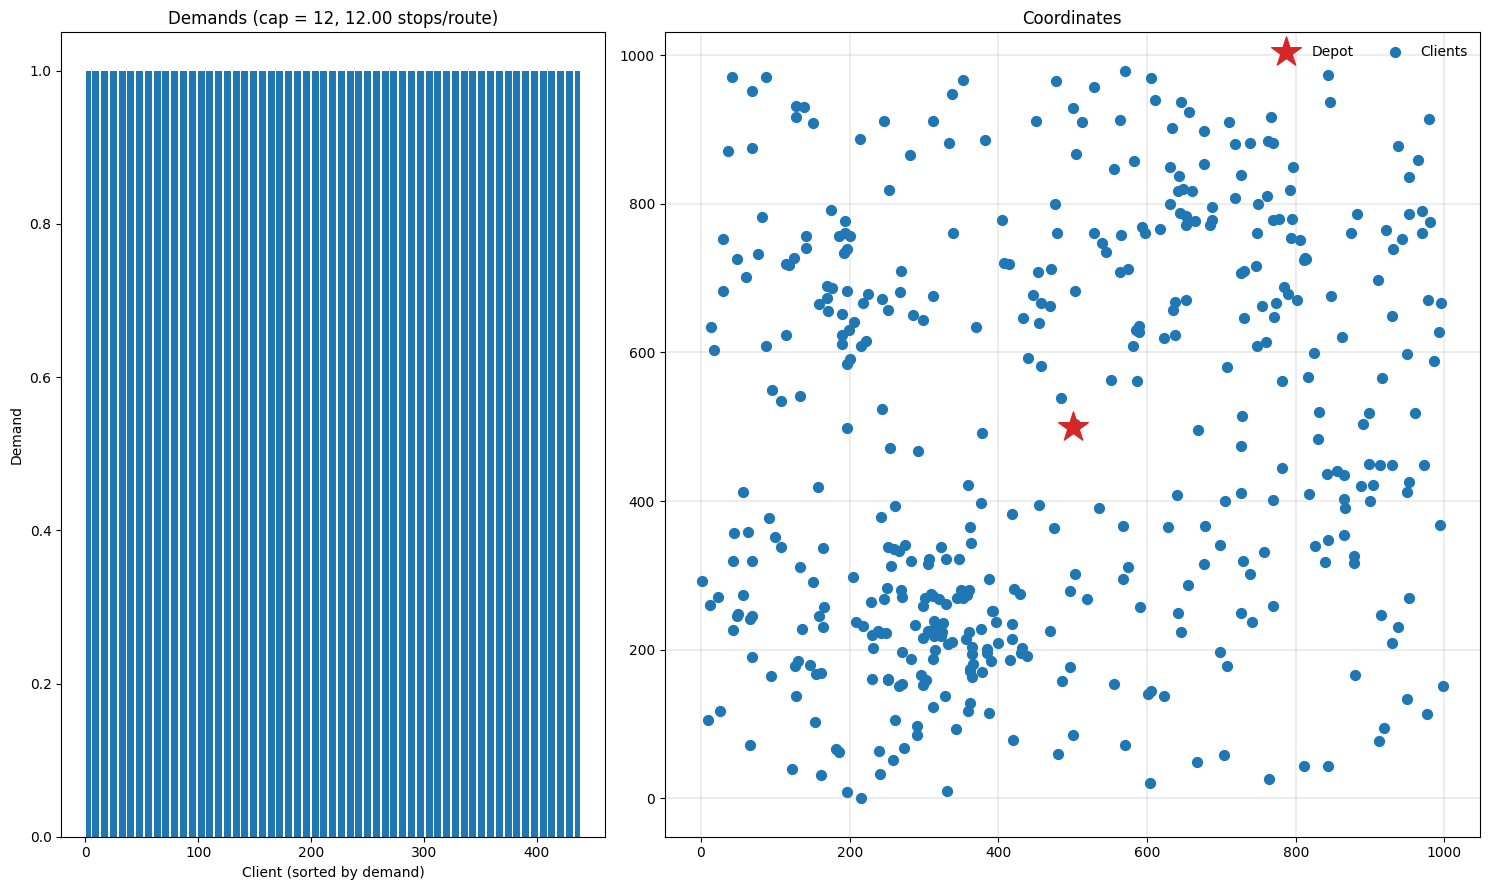

In [40]:
fig = plt.figure(figsize=(15, 9))
gs = fig.add_gridspec(2, 2, width_ratios=(2 / 5, 3 / 5))

plotting.plot_demands(instance, ax=fig.add_subplot(gs[:, 0]))
plotting.plot_coordinates(instance, ax=fig.add_subplot(gs[:, 1]))

plt.tight_layout()

In [44]:
def solve(
    data: ProblemData,
    seed: int,
    max_runtime: Optional[float] = None,
    max_iterations: Optional[int] = None,
    **kwargs,
):
    rng = XorShift128(seed=seed)
    pen_manager = PenaltyManager(data.vehicle_capacity)
    pop = Population(data, pen_manager, rng, bpd)
    ls = LocalSearch(data, pen_manager, rng, compute_neighbours(data))

    node_ops = [node_op(data, pen_manager) for node_op in NODE_OPERATORS]

    for op in node_ops:
        ls.add_node_operator(op)

    route_ops = [route_op(data, pen_manager) for route_op in ROUTE_OPERATORS]

    for op in route_ops:
        ls.add_route_operator(op)

    ga_params = GeneticAlgorithmParams(
        intensify_probability=1, collect_statistics=True
    )
    algo = GeneticAlgorithm(data, pen_manager, rng, pop, ls, srex, ga_params)

    if max_runtime is not None:
        stop = MaxRuntime(max_runtime)
    else:
        assert max_iterations is not None
        stop = MaxIterations(max_iterations)

    return algo.run(stop)

In [45]:
def report_gap(result, bks):
    objective = result.best.cost()
    bks_cost = bks["cost"]
    pct_diff = 100 * (objective - bks_cost) / bks_cost

    print(f"Found a solution with cost: {objective}.")
    print(f"This is {pct_diff:.1f}% worse than the best known", end=" ")
    print(f"solution, which is {bks_cost}.")


result = solve(instance, seed=42, max_runtime=30)
report_gap(result, instance_bks)

Found a solution with cost: 36569.
This is 0.5% worse than the best known solution, which is 36391.


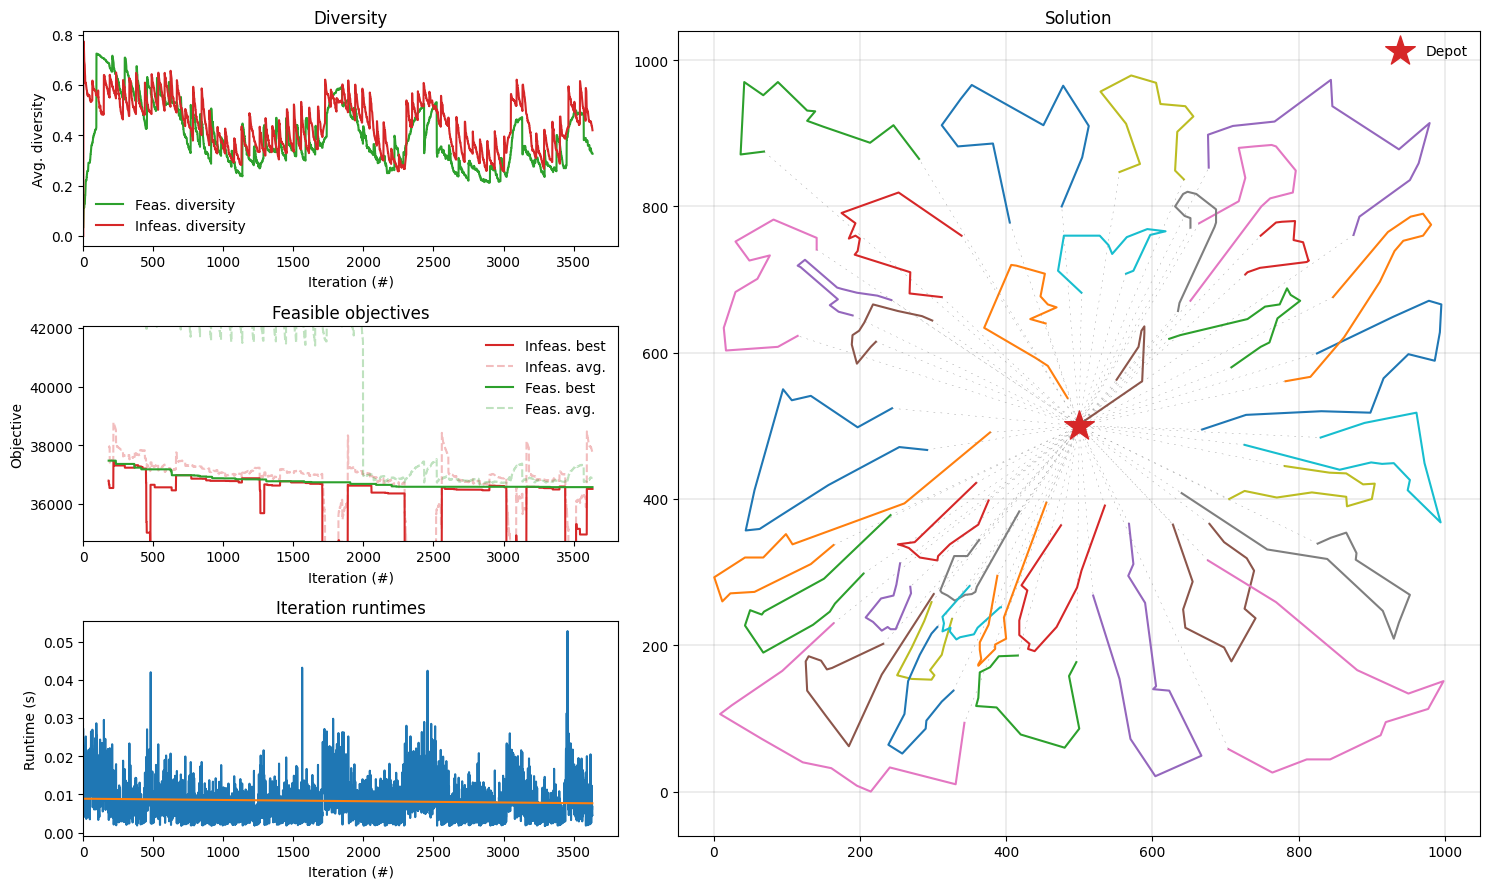

In [46]:
def plot_result(result, instance):
    fig = plt.figure(figsize=(15, 9))
    plotting.plot_result(result, instance, fig)
    fig.tight_layout()


plot_result(result, instance)